In [2]:
import pandas as pd
import numpy as np

data = np.load('morgan_fp.npz')
fp_smiles = pd.read_csv('fp_smiles.csv')

In [3]:
for name in data.files:
    print(f"Массив: {name}")
    print(data[name])
    print("---")

Массив: indices
[  13   80  147 ... 1873 1954 1970]
---
Массив: indptr
[       0       19       34 ... 15295966 15296019 15296075]
---
Массив: format
np.bytes_(b'csr')
---
Массив: shape
[339061   2048]
---
Массив: data
[1 1 1 ... 1 1 1]
---


In [4]:
from scipy.sparse import csr_matrix

# Восстанавливаем матрицу из массивов
sparse_matrix = csr_matrix(
    (data['data'], data['indices'], data['indptr']),
    shape=tuple(data['shape'])
)

print(f"Размерность матрицы: {sparse_matrix.shape}")
print(f"Количество ненулевых элементов: {sparse_matrix.nnz}")

Размерность матрицы: (339061, 2048)
Количество ненулевых элементов: 15296075


In [5]:
# Преобразуем разреженную матрицу в DataFrame
matrix_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)

# Объединяем с основным датасетом по строкам
combined_df = pd.concat([fp_smiles, matrix_df], axis=1)

In [38]:
display(combined_df)

,index,smiles,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CC(=O)OCC[N+](C)(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,C[N+](C)(C)CC(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,O=C(O)c1ccccc1O,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339056,339056,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(c3cccc4ncccc34)C...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339057,339057,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(c3ccncc3)C2=O)cc1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339058,339058,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(Cc3cccc(Cl)c3)C2...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339059,339059,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(Cc3ccccc3)C2=O)cc1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Основная статистика разреженности
print(f"Размер: {sparse_matrix.shape}")
print(f"Заполненность: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.4f}")
print(f"Ненулевых элементов: {sparse_matrix.nnz}")

# Распределение по строкам
non_zero_per_row = np.diff(sparse_matrix.indptr)
print(f"Среднее ненулевых в строке: {non_zero_per_row.mean():.1f}")

Размер: (339061, 2048)
Заполненность: 0.0220
Ненулевых элементов: 15296075
Среднее ненулевых в строке: 45.1


Разреженность: 0.9780


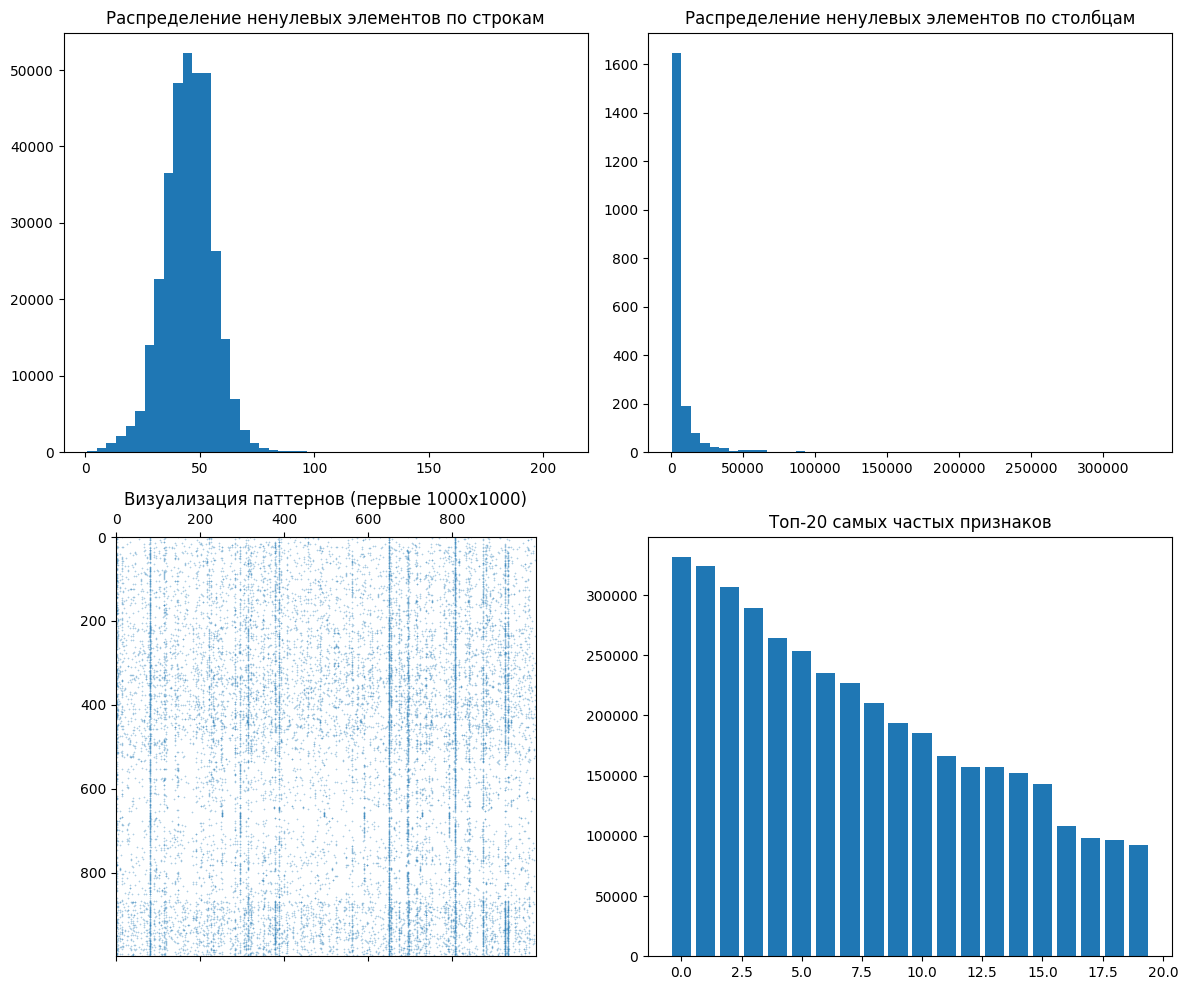

In [7]:
# 1. Анализ разреженности
sparsity = 1 - (sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))
print(f"Разреженность: {sparsity:.4f}")

# 2. Распределение ненулевых элементов по строкам и столбцам
row_nonzeros = np.diff(sparse_matrix.indptr)
col_nonzeros = np.bincount(sparse_matrix.indices)

# 3. Визуализация
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Гистограмма заполненности строк
axes[0,0].hist(row_nonzeros, bins=50)
axes[0,0].set_title('Распределение ненулевых элементов по строкам')

# Гистограмма заполненности столбцов
axes[0,1].hist(col_nonzeros, bins=50)
axes[0,1].set_title('Распределение ненулевых элементов по столбцам')

# Heatmap небольшой части матрицы
axes[1,0].spy(sparse_matrix[:1000, :1000], markersize=0.1)
axes[1,0].set_title('Визуализация паттернов (первые 1000x1000)')

# Топ самых частых столбцов
axes[1,1].bar(range(20), sorted(col_nonzeros, reverse=True)[:20])
axes[1,1].set_title('Топ-20 самых частых признаков')

plt.tight_layout()
plt.show()

# 4. Корреляция между самыми частыми признаками
dense_small = sparse_matrix[:, np.argsort(col_nonzeros)[-100:]].toarray()  # топ-100 признаков
correlation_matrix = np.corrcoef(dense_small.T)

Разберём результаты EDA:

Основные характеристики:
 - Размер матрицы: (339 061 × 2 048)
   - 339 061 соединение (строки) × 2 048 признаков (столбцы)
 - Заполненность: 0.0220
   - ~2.2 % элементов ненулевые, то есть матрица очень разрежённая (97.8 % нулей).
 - Количество ненулевых элементов: 15 296 075
 - Среднее ненулевых в строке: ~45
   - В среднем у каждого соединения активно около 45 признаков из 2048, что немного, но достаточно для различимости.

Анализ графиков:
1. Распределение ненулевых элементов по строкам (верхний левый график)
 - Гистограмма показывает колоколоподобное распределение с центром около 45 ненулевых значений.
 - Практически все строки имеют 20–80 активных признаков.
 - Аномалий (соединений с необычно большим или маленьким количеством признаков) почти нет.
 - Это говорит о однородности химических структур по количеству активных дескрипторов.

2. Распределение ненулевых элементов по столбцам (верхний правый график)
 - Распределение сильно скошено вправо (long tail).
 - Большинство признаков встречаются редко (меньше 10 000 раз), но есть несколько сверхчастых признаков, встречающихся десятки и даже сотни тысяч раз.
 - Это типичная ситуация для one-hot или бинарных признаков химических структур (fingerprints) — многие признаки редки, а некоторые встречаются повсеместно.
 - Стоит обратить внимание на такие частые признаки — возможно, они малоинформативны (шум или общие химические свойства).

3. Визуализация паттернов (нижний левый график)
 - Визуализация первых 1000×1000 элементов показывает «снежный» паттерн: равномерное, но редкое распределение точек.
 - Видны вертикальные полосы — признаки, активные у большого числа соединений.
 - Это согласуется с предыдущим графиком — некоторые признаки встречаются почти у всех образцов.
 - Можно рассмотреть удаление или регуляризацию этих признаков для повышения чувствительности модели.

4. Топ-20 самых частых признаков (нижний правый график)
 - Разница между самым и 20-м по частоте признаком — примерно в 2–3 раза.
 - Верхние признаки встречаются более чем у 300 000 соединений (из 339 000).
 - Такие признаки не дискриминируют токсичные и нетоксичные вещества, так как они слишком общие.
 - Их можно исключить при построении модели или понизить их вес (например, с помощью TF-IDF, variance threshold или mutual information).

Выводы:
 - Матрица сильно разрежённая (97.8 %), что требует эффективного хранения (scipy.sparse формат) и специальных моделей (например, линейных моделей с L1-регуляризацией или деревьев, оптимизированных под sparse input).
 - Распределение по строкам — равномерное, что хорошо для стабильности обучения.
 - Распределение по столбцам — крайне неравномерное, есть признаки с чрезмерной частотой → стоит провести отбор признаков.
 - Общие признаки могут снижать качество классификации токсичности → полезно рассмотреть feature selection.
 - Редкие признаки (встречающиеся в <0.01 % случаев) тоже могут быть удалены как шум.

Далее следует дополняющий блок кода, который:
Вычислит статистики по признакам.
Удалит слишком частые и слишком редкие признаки (по настраиваемым порогам).
Вернёт обновлённую версию combined_df с очищенной матрицей.


Статистика признаков ДО фильтрации:
           feature          count    frequency
count  2048.000000    2048.000000  2048.000000
mean   1023.500000    7468.786621     0.022028
std     591.350996   22444.323378     0.066196
min       0.000000     374.000000     0.001103
1%       20.470000     579.290000     0.001709
5%      102.350000     806.700000     0.002379
50%    1023.500000    2591.500000     0.007643
95%    1944.650000   23588.200000     0.069569
99%    2026.530000   91624.090000     0.270229
max    2047.000000  331746.000000     0.978426

После частотной фильтрации: 2045 из 2048 признаков

До фильтрации:
 - Размер: (339061, 2048)
 - Ненулевых элементов: 15,296,075
 - Среднее ненулевых в строке: 45.11
 - Разрежённость: 0.9780

После фильтрации:
 - Размер: (339061, 2045)
 - Ненулевых элементов: 14,334,123
 - Среднее ненулевых в строке: 42.28
 - Разрежённость: 0.9793


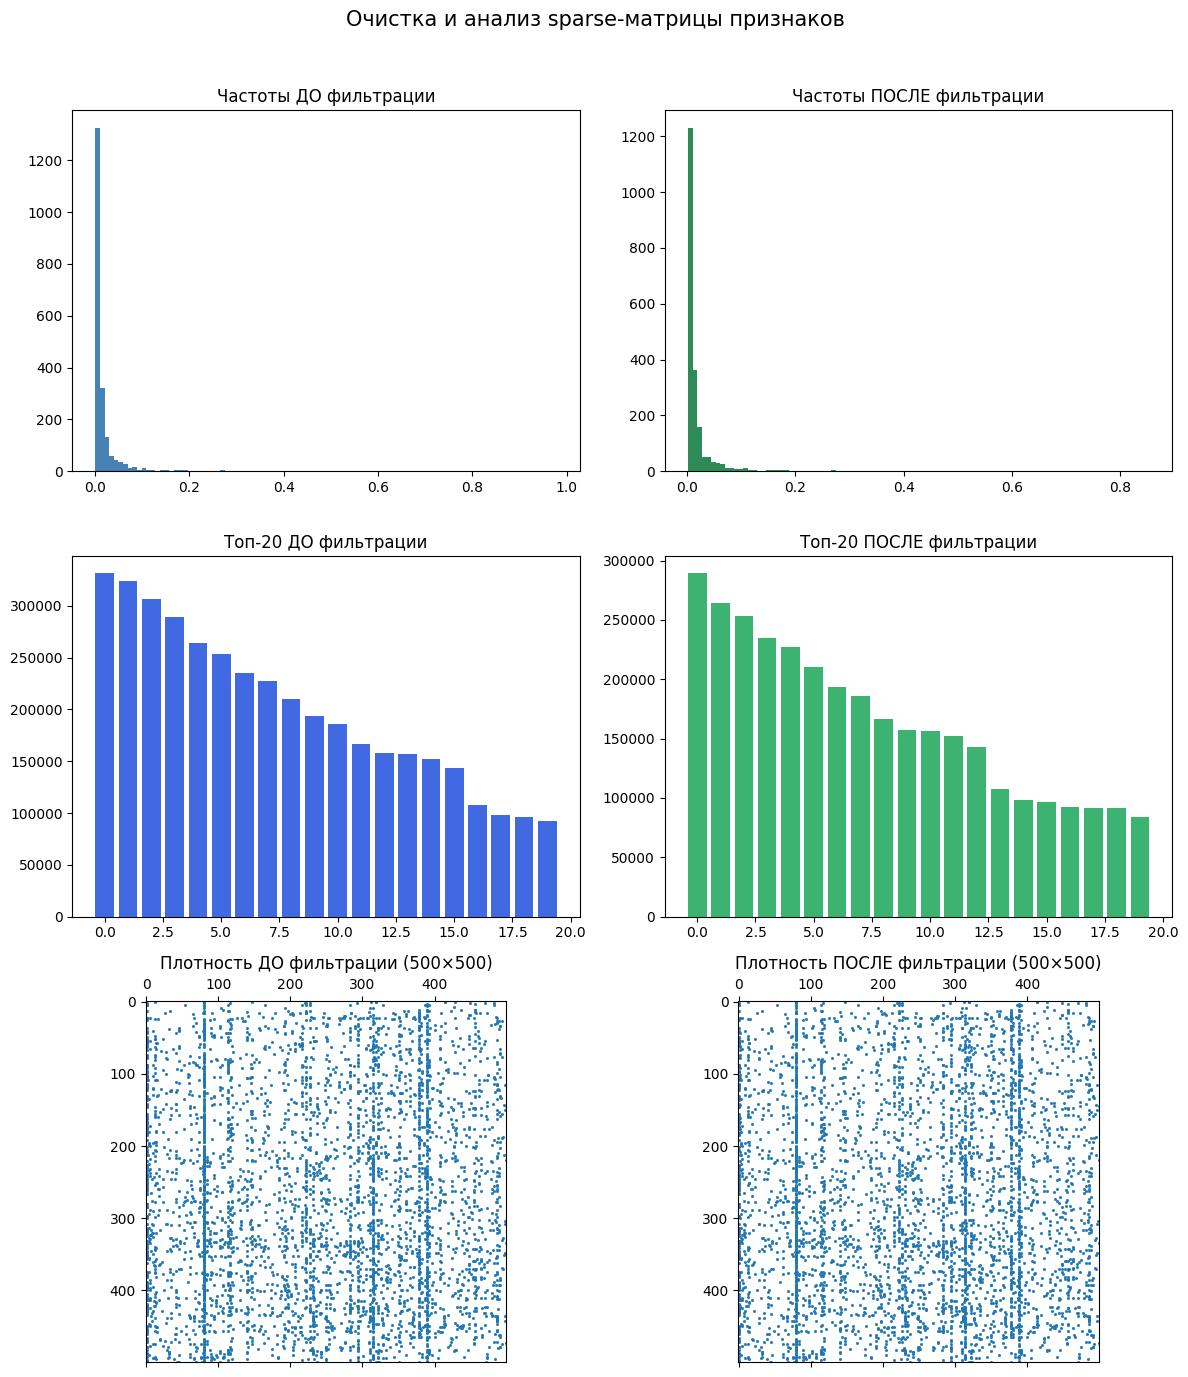


Удаляем 0 коррелированных признаков (|r|>0.95)
Найдено 2045 кластеров признаков

После кластеризации Jaccard (масштабируемая версия):
 - Размер: (339061, 2045)
 - Ненулевых элементов: 14,334,123
 - Среднее ненулевых в строке: 42.28
 - Разрежённость: 0.9793

Финальная размерность combined_df_final: (339061, 2047)


In [8]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score

# === Базовая статистика ===
# Цель: понять распределение признаков и их встречаемость.
# sparse_matrix != 0 создаёт булеву матрицу, где True = ненулевой элемент.
# sum(axis=0) считает, сколько соединений (строк) имеют каждый признак.
# feature_stats — DataFrame с тремя колонками:
#    - feature — индекс признака
#    - count — число ненулевых элементов
#    - frequency — доля соединений, где признак присутствует.
feature_counts = np.array((sparse_matrix != 0).sum(axis=0)).flatten()
n_samples = sparse_matrix.shape[0]

feature_stats = pd.DataFrame({
    'feature': np.arange(sparse_matrix.shape[1]),
    'count': feature_counts,
    'frequency': feature_counts / n_samples
})

print("\nСтатистика признаков ДО фильтрации:")
print(feature_stats.describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

# === Фильтрация по частоте ===
# Цель: снизить шум и разрежённость, удалить признаки с минимальной/максимальной вариабельностью.
# Убирает слишком редкие признаки (<0.1%) и слишком частые (>90%).
# Обновляет матрицу: остаются только признаки с адекватной частотой.
min_freq = 0.001
max_freq = 0.90

mask = (feature_stats['frequency'] >= min_freq) & (feature_stats['frequency'] <= max_freq)
selected_features = feature_stats.loc[mask, 'feature'].values
filtered_stats = feature_stats[mask]

print(f"\nПосле частотной фильтрации: {len(selected_features)} из {sparse_matrix.shape[1]} признаков")

sparse_matrix_filtered = sparse_matrix[:, selected_features]

# === Метрики плотности ===
# Цель: оценить, как фильтрация влияет на плотность матрицы.
# Вычисляет:
#   - размер матрицы,
#   - количество ненулевых элементов,
#   - среднее число ненулевых в строке,
#   - разрежённость (1 - плотность).
def get_sparsity_info(matrix, name="Матрица"):
    total_elements = matrix.shape[0] * matrix.shape[1]
    nonzero_elements = matrix.count_nonzero()
    sparsity = 1 - (nonzero_elements / total_elements)
    avg_nonzeros_per_row = nonzero_elements / matrix.shape[0]
    print(f"\n{name}:")
    print(f" - Размер: {matrix.shape}")
    print(f" - Ненулевых элементов: {nonzero_elements:,}")
    print(f" - Среднее ненулевых в строке: {avg_nonzeros_per_row:.2f}")
    print(f" - Разрежённость: {sparsity:.4f}")
    return sparsity, avg_nonzeros_per_row

sparsity_before, avg_before = get_sparsity_info(sparse_matrix, "До фильтрации")
sparsity_after, avg_after = get_sparsity_info(sparse_matrix_filtered, "После фильтрации")

# === Визуализация плотности и распределений ===
# Цель: визуально оценить эффект фильтрации и плотность матрицы.
# Строит гистограммы частот до и после фильтрации.
# Строит топ-20 наиболее частых признаков.
# spy визуализирует структуру разреженности (ненулевые элементы) для 500×500 элементов.
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle("Очистка и анализ sparse-матрицы признаков", fontsize=15)

axes[0, 0].hist(feature_stats['frequency'], bins=100, color='steelblue')
axes[0, 0].set_title("Частоты ДО фильтрации")
axes[0, 1].hist(filtered_stats['frequency'], bins=100, color='seagreen')
axes[0, 1].set_title("Частоты ПОСЛЕ фильтрации")

top_before = feature_stats.sort_values('count', ascending=False).head(20)
axes[1, 0].bar(range(20), top_before['count'], color='royalblue')
axes[1, 0].set_title("Топ-20 ДО фильтрации")
top_after = filtered_stats.sort_values('count', ascending=False).head(20)
axes[1, 1].bar(range(20), top_after['count'], color='mediumseagreen')
axes[1, 1].set_title("Топ-20 ПОСЛЕ фильтрации")

sample_size = min(500, sparse_matrix.shape[0])
axes[2, 0].spy(sparse_matrix[:sample_size, :500], markersize=1)
axes[2, 0].set_title("Плотность ДО фильтрации (500×500)")
axes[2, 1].spy(sparse_matrix_filtered[:sample_size, :500], markersize=1)
axes[2, 1].set_title("Плотность ПОСЛЕ фильтрации (500×500)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# === Корреляционный анализ (по выборке) ===
# Цель: удалить избыточные признаки, которые несут одинаковую информацию.
# Берёт подвыборку строк для плотной матрицы.
# Считает корреляцию между признаками.
# Убирает признаки с сильной корреляцией (|r| > 0.95).
sample_n = min(5000, sparse_matrix_filtered.shape[0])
dense_sample = sparse_matrix_filtered[:sample_n].toarray()

corr_matrix = np.corrcoef(dense_sample, rowvar=False)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr = np.abs(corr_matrix) > 0.95
high_corr = np.where(upper & high_corr)
to_drop_corr = np.unique(high_corr[1])

print(f"\nУдаляем {len(to_drop_corr)} коррелированных признаков (|r|>0.95)")
remaining_idx = np.setdiff1d(np.arange(sparse_matrix_filtered.shape[1]), to_drop_corr)
sparse_matrix_nocorr = sparse_matrix_filtered[:, remaining_idx]

import numpy as np
import scipy.sparse as sp
import networkx as nx

# === Масштабируемая кластеризация по Jaccard ===
# Преобразуем подвыборку в булеву sparse-матрицу.
# Создаём граф G, где вершины — признаки, а рёбра — пары с Jaccard > 0.95.
# Для каждой пары признаков вычисляем Jaccard на лету:
# Соединяем пары с высокой схожестью.
n_features = sparse_matrix_nocorr.shape[1]
threshold_jaccard = 0.95

sample_n = min(5000, sparse_matrix_nocorr.shape[0])
sparse_sample = sparse_matrix_nocorr[:sample_n, :].astype(bool).tocsc()

G = nx.Graph()
G.add_nodes_from(range(n_features))

for i in range(n_features):
    col_i = sparse_sample[:, i].tocoo()
    set_i = set(col_i.row)
    for j in range(i + 1, n_features):
        col_j = sparse_sample[:, j].tocoo()
        set_j = set(col_j.row)
        intersection = len(set_i & set_j)
        union = len(set_i | set_j)
        if union == 0:
            continue
        jaccard = intersection / union
        if jaccard > threshold_jaccard:
            G.add_edge(i, j)

# === Определение кластеров ===
# Цель: избавиться от сильно схожих бинарных признаков, оставив один представитель из каждой группы.
# connected_components(G) находит группы взаимосвязанных признаков (кластер).
# Из каждого кластера берём один признак.
# Формируем окончательную матрицу sparse_matrix_final_clustered.
clusters = list(nx.connected_components(G))
print(f"Найдено {len(clusters)} кластеров признаков")

selected_features_clustered = [list(c)[0] for c in clusters]
sparse_matrix_final_clustered = sparse_matrix_nocorr[:, selected_features_clustered]

# === Финальные метрики ===
# Считаем разрежённость, количество ненулевых элементов, среднее ненулевых на строку.
def get_sparsity_info(matrix, name="Матрица"):
    total_elements = matrix.shape[0] * matrix.shape[1]
    nonzero_elements = matrix.count_nonzero()
    sparsity = 1 - (nonzero_elements / total_elements)
    avg_nonzeros_per_row = nonzero_elements / matrix.shape[0]
    print(f"\n{name}:")
    print(f" - Размер: {matrix.shape}")
    print(f" - Ненулевых элементов: {nonzero_elements:,}")
    print(f" - Среднее ненулевых в строке: {avg_nonzeros_per_row:.2f}")
    print(f" - Разрежённость: {sparsity:.4f}")

get_sparsity_info(sparse_matrix_final_clustered, "После кластеризации Jaccard (масштабируемая версия)")

# === Финальный DataFrame ===
# Преобразует финальную sparse-матрицу в DataFrame с понятными колонками.
# Объединяет с fp_smiles (SMILES химических соединений) для готовой таблицы.
# Выводит размерность финального набора данных.
final_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_final_clustered)
final_df.columns = [f"f_{i}" for i in range(sparse_matrix_final_clustered.shape[1])]
combined_df_final = pd.concat([fp_smiles, final_df], axis=1)

print(f"\nФинальная размерность combined_df_final: {combined_df_final.shape}")

## Анализ
1. Статистика признаков ДО фильтрации:
     - Всего признаков: 2048
     - Средняя частота присутствия признака: ~2.2%
     - Большинство признаков редкие: медиана частоты = 0.76%, 95-й перцентиль = 6.96%
     - Есть очень частые признаки: max ≈ 97.8%

       Вывод:
     - Данные сильно разреженные.
     - Большинство признаков встречается редко, что типично для химических дескрипторов (fingerprints).
     - Есть несколько очень частых признаков, которые могут не давать полезной информации.

2. Фильтрация по частоте:
     - После фильтрации удалено всего 3 признака (2045/2048 осталось).
     - Среднее число ненулевых в строке уменьшилось с 45.11 → 42.28
     - Разрежённость чуть увеличилась (0.978 → 0.9793)

       Вывод:
     - Почти все признаки проходили по порогам частоты (0.1% < freq < 90%)
     - Фильтрация по частоте не сильно изменила матрицу, но слегка убрала очень редкие/частые признаки.

3. Корреляционный анализ:
     - Количество коррелированных признаков (|r|>0.95): 0

       Вывод:
     - Признаки почти не коррелируют линейно.
     - Это говорит о том, что каждый дескриптор вносит уникальную информацию для соединений.

4. Кластеризация по Jaccard:
     - Количество кластеров: 2045
     - После кластеризации по Jaccard матрица осталась того же размера.

       Вывод:
     - Почти все бинарные признаки различны: нет групп сильно схожих признаков (J > 0.95).
     - Это означает, что дескрипторы химических соединений хорошо разнообразны и не содержат дублирующих паттернов.

5. Финальная матрица:
     - Размер: 339061 × 2045 (добавлено SMILES → 339061 × 2047)
     - Среднее ненулевых в строке: 42.28
     - Разрежённость: 0.9793

       Вывод:
     - Финальная матрица остаётся разрежённой (≈98% нулей).
     - Фильтрации и кластеризации почти не изменили структуру матрицы, что говорит о высоком разнообразии признаков.
     - Можно использовать для машинного обучения без сильной потери информации.

6. Итоговые наблюдения:
     - Данные разреженные, большинство признаков встречаются редко.
     - Почти нет коррелированных признаков, что хорошо для моделей — каждый признак уникален.
     - Нет сильно схожих бинарных дескрипторов — кластеризация по Jaccard почти не сократила количество признаков.
     - Финальная матрица готова к обучению: разрежённая, уникальные дескрипторы, минимальная избыточность.

7. Практическое значение:
     - Можно смело использовать все признаки в моделях, не опасаясь дублирования информации.
     - Разрежённость и редкость признаков нужно учитывать при выборе моделей (например, Sparse-aware модели: XGBoost, LightGBM, Logistic Regression с sparse input).
     - Данный анализ подтвердил, что данные чистые, информативные и сбалансированные по уникальности дескрипторов.

## Дальнейшие варианты действий и перспективы
1. Выбор модели:
    Так как матрица разрежённая (~98% нулей) и бинарная:
     - Sparse-aware модели предпочтительнее:
       - LightGBM (LGBMClassifier / LGBMRegressor) с sparse input.
       - XGBoost (XGBClassifier / XGBRegressor) с sparse матрицей.
       - LogisticRegression / SGDClassifier с scipy.sparse (для классификации).
     - Почему:
       - Такие модели эффективно используют память.
       - Не создают плотных матриц, что ускоряет обучение.
    
    
2. Обработка редких признаков:
     - Большинство признаков встречается редко (<1%).
     - В некоторых моделях (например, нейронные сети) редкие признаки могут плохо обучаться.

    Стратегия:
     - Для Gradient Boosting / Tree-based моделей можно оставить все признаки, так как они умеют работать с разреженными бинарными признаками.
     - Для линейных моделей: можно объединять редкие признаки или использовать feature hashing, если признаков станет ещё больше (например, >100k).
    
    
3. Масштабирование и нормализация:
     - Не нужно масштабировать бинарные признаки (0/1).
     - Для моделей, чувствительных к масштабу (например, SVM с RBF), можно оставить 0/1 как есть или применить StandardScaler только для плотных численных признаков, если они будут добавлены.
    
    
4. Разрежённость и хранение:
     - Хранить матрицу как sparse matrix (scipy.sparse.csr_matrix).
     - Конвертировать в pandas.DataFrame.sparse только для удобства объединения с SMILES.
     - При обучении передавать напрямую sparse-матрицу в модель, чтобы не тратить память.
    
    
5. Feature selection (опционально):
     - Ты уже убрал сильно коррелированные признаки и кластеризовал схожие признаки по Jaccard.
     - Если признаки будут динамически увеличиваться, можно применять:
       - VarianceThreshold (для удаления сверхредких признаков).
       - Tree-based feature importance после первого обучения для отбора значимых признаков.
    
    
6. Разделение данных:
     - Разделение на train/test/validation с учётом редких признаков:
       - Редкие признаки должны быть представлены хотя бы в нескольких примерах каждого набора.
       - Для бинарных дескрипторов можно использовать stratified split по целевой переменной, если она категориальная.
    
    
7. Работа с классами и балансом (для классификации):
     - Для токсичности часто наблюдается несбалансированность классов (мало токсичных соединений).
     - Стратегии:
       - class_weight='balanced' в линейных моделях или LightGBM/XGBoost.
       - Oversampling редких классов (SMOTE) — аккуратно, чтобы не создавать искусственные бинарные паттерны.
       - Метрики: AUC, F1-score, PR-AUC — более информативны, чем точность.
    
    
8. Итоговая рекомендация:
     - Оставить все признаки, так как они уникальные и не коррелируют.
     - Использовать разрежённый формат (csr_matrix) при обучении.
     - Выбирать sparse-aware модели, например, LightGBM или XGBoost.
     - Оценивать модели с метриками, подходящими для разрежённых и несбалансированных данных (AUC, F1).
     - Опционально: после первого обучения можно использовать feature importance для дальнейшей редукции признаков.
    
    
9. Вывод:
     - Матрица готова к обучению.
     - Все признаки уникальны и информативны.
     - Разрежённость и редкость признаков учтены.
     - Модель сможет эффективно учиться без дополнительного удаления признаков.

# Код генерации Morgan Fingerprints

Что такое Morgan Fingerprints

Morgan Fingerprints — это один из видов дескрипторов молекул, который широко используется в химоинформатике.

Идея: кодировать молекулу в бинарный вектор, где каждый бит соответствует наличию определённого химического фрагмента (подструктуры) в молекуле.

Процесс генерации:
 - Молекула представляется в виде графа: атомы — вершины, связи — рёбра.
 - Для каждого атома создаётся "окружение" заданного радиуса (например, 2-атомных связей).
 - Эти окружения хэшируются в битовую строку фиксированной длины (обычно 1024 или 2048 бит).

Результат:
 - Бинарная матрица: строки = молекулы, столбцы = признаки/битовые позиции.
 - 1 — данный фрагмент присутствует в молекуле, 0 — отсутствует.

Преимущества:
 - Хорошо отражает химическую структуру.
 - Можно использовать в ML/DL моделях для предсказания свойств, активности или токсичности.

Параметры:
 - radius — радиус окружения атомов.
 - nBits — длина вектора (2048 в нашем случае).
 - Генерируется через RDKit (функция AllChem.GetMorganFingerprintAsBitVect).

In [ ]:
"""
Генерация Morgan Fingerprints для молекул  
Источник: RDKit Documentation - Molecular Fingerprints  
Morgan, H. L. (1965). The Generation of a Unique Machine 
Description for Chemical Structures-A Technique Developed at Chemical Abstracts Service.  
"""

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from scipy import sparse
from tqdm import tqdm
import os

# Параметры обработки
input_csv = r"C:\Users\user\Desktop\токс\full_combined_cleaned.csv"  # входной файл с SMILES
out_dir = r"C:\Users\user\Desktop\токс\fp_data"  # директория для результатов

# Параметры Morgan fingerprints
radius = 2  # радиус для рассмотрения атомных окружений (обычно 2-3)
nBits = 2048  # размер битового вектора (стандартные значения: 1024, 2048, 4096)
batch_size = 50000  # размер батча для обработки (оптимизация использования памяти)

# Отключаем предупреждения RDKit для чистого вывода
RDLogger.DisableLog('rdApp.*')

# Чтение SMILES и фильтрация уникальных значений
# Используем set для быстрого определения уникальности
smiles_set = set()  # для проверки уникальности
smiles_list = []    # для сохранения порядка

# Чтение файла чанками для обработки больших файлов
for chunk in pd.read_csv(input_csv, usecols=['smiles'], chunksize=5000):
    for smi in chunk['smiles']:
        if pd.isna(smi):  # пропускаем NaN значения
            continue
        smi = smi.strip()  # удаляем пробелы
        if smi not in smiles_set:  # проверяем уникальность
            smiles_set.add(smi)
            smiles_list.append(smi)  # сохраняем в списке

N = len(smiles_list)  # общее количество уникальных SMILES
print(f"Всего уникальных SMILES: {N}")

# Подготовка для логирования некорректных SMILES
invalid_smiles = []  # список для невалидных SMILES

# Обработка батчами для экономии оперативной памяти
# Используем списки для координат ненулевых элементов разреженной матрицы
rows, cols = [], []  # rows - индексы молекул, cols - установленные биты

print("Вычисление Morgan fingerprints батчами...")
# Обрабатываем данные батчами с прогресс-баром
for start in tqdm(range(0, N, batch_size), desc="Обработка батчей"):
    batch_end = min(start + batch_size, N)  # конец текущего батча
    for i in range(start, batch_end):  # обработка молекул в батче
        smi = smiles_list[i]  # получаем SMILES строку
        mol = Chem.MolFromSmiles(smi)  # конвертируем SMILES в молекулу RDKit
        if mol is None:
            invalid_smiles.append(smi)  # сохраняем невалидные SMILES
            continue
        
        # Генерация Morgan fingerprint как битового вектора
        # Алгоритм рассматривает окружения каждого атома в заданном радиусе
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        
        # Получаем индексы установленных битов (ненулевые позиции)
        onbits = list(bv.GetOnBits())
        
        # Добавляем координаты в разреженную матрицу
        # Для каждой молекулы добавляем ее индекс и позиции установленных битов
        rows.extend([i] * len(onbits))  # дублируем индекс молекулы для каждого бита
        cols.extend(onbits)  # добавляем позиции установленных битов

# Создание финальной разреженной матрицы в формате CSR (Compressed Sparse Row)
# CSR формат эффективен для матричных операций и занимает меньше памяти
data = np.ones(len(rows), dtype=np.uint8)  # все ненулевые элементы = 1
# Создаем координатную матрицу (COO) и конвертируем в CSR
csr = sparse.coo_matrix((data, (rows, cols)), shape=(N, nBits), dtype=np.uint8).tocsr()

# Сохранение результатов
# Сохраняем разреженную матрицу в формате NPZ
sparse.save_npz(os.path.join(out_dir, 'morgan_fp.npz'), csr)

# Создаем CSV файл с соответствием индексов и SMILES
df_smiles = pd.DataFrame({
    'index': np.arange(N),  # индекс молекулы в матрице
    'smiles': smiles_list   # соответствующий SMILES
})
df_smiles.to_csv(os.path.join(out_dir, 'fp_smiles.csv'), index=False)

print("Обработка завершена.")